## Analiza zarobków analityków danych i zawodów pokrewnych na świecie z podziałem na stanowiska. 

[Górski Szymon](https://github.com/SzymonTomasz), [Szura Michał](https://github.com/Malamity) i [Stano Paweł](https://github.com/pstano1)

#### Spis treści:
- [Wstęp](#wstep)
- [Metodologia](#metodologia)
- [Podział stanowisk](#podzial-stanowisk)
- [Wnioski](#wnioski)

TODO:
- read csv do dataframe
- clean data (sprawdzic w wykladzie) na przyklad dropnan/inan (opcjonalnie usunięcie wartości skrajnych)
- analiza: group by (np country/stanowisko/firma) + miary tendencji centralnej (oda, mediana, średnia)
- Wykres do powyzszego.

jak zdążymy:
- analiza wewnątrze dla wybranego przez usera kraj (np breakdown by stanowisko/firma)
- analiza per firma niezależnie od kraju
- analiza per stanowisko
- zaczynamy od pisania tego w funkcjach, jak zdążymy wrzucamy fnkcje na metody wewnętrzne obietu

:bulb: porównanie w parytecie, natomaist to wymagałoby znaleźenia danych indeksów CPI

### Wstęp

Analityka danych i pokrewne zawody stały się nieodzowną częścią strategii rozwoju nowoczesnych firm w ostatniej dekadzie. Dzięki zdolności do zbierania, przetwarzania i interpretowania danych, specjaliści w tej dziedzinie pomagają firmom podejmować lepsze decyzje biznesowe i zyskiwać przewagę konkurencyjną. Wzrost znaczenia analizy danych wiąże się również ze wzrostem zarobków specjalistów, co czyni tę profesję atrakcyjną na całym świecie.

Celem tego raportu jest analiza zarobków analityków danych i pokrewnych zawodów na świecie, uwzględniająca różnice między poszczególnymi stanowiskami oraz regionami geograficznymi. 

### Metodologia

#### Źródła danych

W niniejszym raporcie wykorzystano dane pochodzące z kilku głównych źródeł:

1. Zbiór danych o zarobkach: Dane dotyczące wynagrodzeń analityków danych i pokrewnych zawodów zostały pozyskane z platformy `kaggle` i zostały przygotowane na podstiwe danych udostępnionych przez platformę `Glassdoor`, która gromadzi informacje na temat wynagrodzeń pracowników na podstawie raportów zgłaszanych przez użytkowników i analizy rynkowej.

2. Tabele Narodowego Banku Polskiego (NBP): Dane dotyczące kursów walut pochodzą z Tabel Narodowego Banku Polskiego, zapewniając jednolitą bazę do porównań zarobków w różnych regionach geograficznych.

#### Meteody analizy

##### Narzędzia

In [155]:
import requests as re
import json
import base64
import zipfile
import pandas as pd
import csv
import unicodedata
from io import BytesIO, StringIO
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.2f}'.format

In [101]:
salary_file = r'./salaries.csv'
dataset = []
with open(salary_file, newline='', encoding ='utf-8') as csvfile:
    spamreader = csv.reader(csvfile,delimiter='\t', quotechar=u'\xa0')
    for row in spamreader:
        row = [unicodedata.normalize('NFC',i)  for i in row]
        dataset.append(row)

salaries_df = pd.DataFrame(columns = dataset[0][:-1], data = dataset[1:])
salaries_df.head(5)

,role,country,company,company_rating,job_title,median,low,high,unit
0,Data Scientist,Japan,CTW,2.9,Data Scientist,"¥1,500,000",¥1M,¥18M,/yr
1,Data Scientist,Japan,FUJIFILM,3.7,Data Scientist,"¥5,000,000",¥5M,¥7M,/yr
2,Data Scientist,Japan,GMO Internet,3.3,Data Scientist,"¥6,500,000",¥7M,-,/yr
3,Data Scientist,Japan,Data4Cʼs,3,Data Scientist,"¥350,000",¥300K,¥402K,/mo
4,Data Scientist,Japan,Deloitte,4,Data Scientist,"¥6,250,000",¥5M,¥8M,/yr


In [151]:
from typing import Callable

class GlassdoorSalary:
  base_url = "https://www.kaggle.com/api/v1"
  owner = "imbishal7"
  dataset_name = "glassdoor-salary"
  filename = "salaries.csv"
  version = 1

  def __init__(self, username: str, key: str, currency_codes: dict) -> None:
    self.username = username
    self.key = key
    self.currency_symbols = currency_codes

    credentials = base64.b64encode(bytes(f"{self.username}:{self.key}", "ISO-8859-1")).decode("ascii")
    self.headers = {
      "Authorization": f"Basic {credentials}"
    }
    self.dataset = pd.DataFrame()

  def load_dataset(self) -> None:
    '''
      Loads dataset from specified link, unzips it & clears the empty cells
    '''
    url = f'{self.base_url}/datasets/download/{self.owner}/{self.dataset_name}?datasetVersionNumber={self.version}'
    res: re.Response 
    try:
      res = re.get(url, headers=self.headers, stream=True)
    except Exception as e:
      print(e)
      return 
    
    try:
      zf = zipfile.ZipFile(BytesIO(res.content))
      with zf.open(self.filename) as f:
        content = f.read().decode('utf-8')
        f = StringIO(content)
        set = []
        spamreader = csv.reader(f, delimiter='\t', quotechar=u'\xa0')
        for row in spamreader:
            row = [unicodedata.normalize('NFC',i)  for i in row]
            set.append(row)

        self.dataset = pd.DataFrame(columns = set[0][:-1], data = set[1:])
        self.dataset = self.dataset[~self.dataset.isin(['NA', '-']).any(axis=1)]
        self.dataset = self.dataset.dropna()
    except Exception as e:
        print(e)
        return
  
  def process_data(self) -> None:
    '''
      Proccesses the data columns containing money values (median, high, low)
      example: a monetary field of high bound of pay range 
      may be written as $1M, this function clears this mess up
      by writting $ to `currency` as `USD` column & changing 1M into 
      proper numeric value of 1000000
    '''
    def convert_to_proper_number(value):
      multiplier = 1
      if 'K' in value:
          multiplier = 1000
      elif 'M' in value:
          multiplier = 1000000
      value = value.replace('K', '')
      value = value.replace('M', '')
      
      return float(value) * multiplier
  
    currency_codes = self.dataset['median'].str.extract(r'^(\w+)', expand=False)
      
    self.dataset['currency'] = currency_codes.map(self.currency_symbols)
    self.dataset['currency'] = self.dataset['currency'].fillna(currency_codes)
  
    symbols = self.dataset.loc[self.dataset['currency'].isna(), 'median'].str.extract(r'([^\d\.\-KM])', expand=False).fillna('')
    self.dataset['currency'] = self.dataset['currency'].fillna(symbols.map(self.currency_symbols))
        
    self.dataset['currency'] = self.dataset['currency'].fillna(symbols)
    
    self.dataset['median'] = self.dataset['median'].str.replace(r'[^\d\.\-]', '', regex=True).astype(float)
    self.dataset['low'] = self.dataset['low'].str.replace(r'[^\d\.\-KM]', '', regex=True).apply(convert_to_proper_number)
    self.dataset['high'] = self.dataset['high'].str.replace(r'[^\d\.\-KM]', '', regex=True).apply(convert_to_proper_number)

  def get_dataset(self) -> pd.DataFrame:
    return self.dataset
  
  def select_by_hourly_rate(self) -> pd.DataFrame:
    def convert_to_hr_rate(value, unit):
      conversion_factors = {
        '/yr': 12 * 160,
        '/mo': 160,
        '/hr': 1
      }

      return value / conversion_factors[unit]
    
    for col in ['median', 'low', 'high']:
      self.dataset[col] = self.dataset.apply(lambda row: convert_to_hr_rate(row[col], row['unit']), axis=1)
    self.dataset['unit'] = '/hr'

    return self.get_dataset()
  
  def select_by_monthly_rate(self) -> pd.DataFrame:
    def convert_to_mo_rate(value, unit):
      conversion_factors = {
        '/yr': (1/12),
        '/mo': 1,
        '/hr': 160
      }

      return value * conversion_factors[unit]
    
    for col in ['median', 'low', 'high']:
      self.dataset[col] = self.dataset.apply(lambda row: convert_to_mo_rate(row[col], row['unit']), axis=1)
    self.dataset['unit'] = '/mo'

    return self.get_dataset()
  
  def select_by_yearly_rate(self) -> pd.DataFrame:
    def convert_to_mo_rate(value, unit):
      conversion_factors = {
        '/yr': 1,
        '/mo': 12,
        '/hr': 160*12
      }

      return value * conversion_factors[unit]
    
    for col in ['median', 'low', 'high']:
      self.dataset[col] = self.dataset.apply(lambda row: convert_to_mo_rate(row[col], row['unit']), axis=1)
    self.dataset['unit'] = '/yr'

    return self.get_dataset()
  
  def to_common_currency(self, to_currency: str, get_exchange_rate: Callable[[str, str], float]) -> pd.DataFrame:
    '''
      Converts salary data to a specified common currency for unified analysis
    '''
    def convert_value(row, column):
      from_currency = row['currency']
      value = row[column]
      if from_currency == to_currency:
        return value
      exchange_rate = get_exchange_rate(from_currency, to_currency)
      
      return value * exchange_rate
    
    self.dataset[to_currency + '_median'] = self.dataset.apply(lambda row: convert_value(row, 'median'), axis=1)
    self.dataset[to_currency + '_low'] = self.dataset.apply(lambda row: convert_value(row, 'low'), axis=1)
    self.dataset[to_currency + '_high'] = self.dataset.apply(lambda row: convert_value(row, 'high'), axis=1)
    
    return self.get_dataset()
  
  def calculate_mean(self, column: str) -> float:
    return self.dataset[column].mean()
  
  def calculate_grouped_mean(self, group_by: str, column: str) -> pd.DataFrame:
    return self.dataset.groupby(group_by)[column].mean().reset_index()
  
  def get_unique_values(self, column_name: str):
    return self.dataset[column_name].unique()

In [120]:
class ExchangeProvider:
    currencies = {}

    def __init__(self, tables_wanted, currency_symbols):
        self.symbol_map = currency_symbols
        for table_name in tables_wanted:
            json_nbp_curr = re.get(f"http://api.nbp.pl/api/exchangerates/tables/{table_name}/last/1/?format=json").json()
            for rate in json_nbp_curr[0]['rates']:
                self.currencies[rate['code']] = rate['mid']

    def get_rate(self, from_currency, to_currency):
        if from_currency == to_currency:
            return 1

        from_rate = 0
        to_rate = 0

        if to_currency == "PLN":
            return  self.currencies[from_currency]
        elif from_currency == "PLN":
            return 1 / self.currencies[to_currency]
        else:
            try:
                from_rate = self.currencies[from_currency]
            except Exception as e:
                print(f"{e}")
                return -1
            
            try:
                to_rate = self.currencies[to_currency]
            except Exception as e:
                print(f"{e}")
                return -1
            
            return from_rate / to_rate
        
    def exchange_symbol_for_code(self, symbol: str) -> str:
        return self.symbol_map[symbol]


In [131]:
with open('./currencies.json') as f:
    currencies = json.load(f)

exchange_provider = ExchangeProvider(["a", "b"], currencies)

In [152]:
with open('./kaggle.json') as f: 
    credentials = json.load(f)

a = GlassdoorSalary(credentials['username'], credentials['key'], currencies)
a.load_dataset()
a.process_data()
a.get_dataset()

,role,country,company,company_rating,job_title,median,low,high,unit,currency
0,Data Scientist,Japan,CTW,2.9,Data Scientist,"1,500,000.00","1,000,000.00","18,000,000.00",/yr,JPY
1,Data Scientist,Japan,FUJIFILM,3.7,Data Scientist,"5,000,000.00","5,000,000.00","7,000,000.00",/yr,JPY
3,Data Scientist,Japan,Data4Cʼs,3,Data Scientist,"350,000.00","300,000.00","402,000.00",/mo,JPY
4,Data Scientist,Japan,Deloitte,4,Data Scientist,"6,250,000.00","5,000,000.00","8,000,000.00",/yr,JPY
5,Data Scientist,Japan,Indeed,4.1,Data Scientist,"20,500,000.00","20,000,000.00","21,000,000.00",/yr,JPY
...,...,...,...,...,...,...,...,...,...,...
401185,Data Engineer,Romania,FinProm,2.9,Data Entry Operator,"3,716.00","4,000.00","4,000.00",/mo,RON
401186,Data Engineer,Romania,GRS,3,Data Entry Operator,"1,612.00","2,000.00","2,000.00",/mo,RON
401187,Data Engineer,Romania,Woods Valldata,2.6,Data Entry Operator,"1,648.00","2,000.00","2,000.00",/yr,RON
401188,Data Engineer,Romania,FM Logistic,3.5,Data Entry Operator,"4,908.00","5,000.00","5,000.00",/mo,RON


In [159]:
a.select_by_yearly_rate()

,role,country,company,company_rating,job_title,median,low,high,unit,currency,EUR_median,EUR_low,EUR_high
0,Data Scientist,Japan,CTW,2.9,Data Scientist,"1,500,000.00","1,000,000.00","18,000,000.00",/yr,JPY,"8,833.63","5,889.09","106,003.55"
1,Data Scientist,Japan,FUJIFILM,3.7,Data Scientist,"5,000,000.00","5,000,000.00","7,000,000.00",/yr,JPY,"29,445.43","29,445.43","41,223.60"
3,Data Scientist,Japan,Data4Cʼs,3,Data Scientist,"4,200,000.00","3,600,000.00","4,824,000.00",/yr,JPY,"2,061.18","1,766.73","2,367.41"
4,Data Scientist,Japan,Deloitte,4,Data Scientist,"6,250,000.00","5,000,000.00","8,000,000.00",/yr,JPY,"36,806.79","29,445.43","47,112.69"
5,Data Scientist,Japan,Indeed,4.1,Data Scientist,"20,500,000.00","20,000,000.00","21,000,000.00",/yr,JPY,"120,726.27","117,781.73","123,670.81"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
401185,Data Engineer,Romania,FinProm,2.9,Data Entry Operator,"44,592.00","48,000.00","48,000.00",/yr,RON,746.61,803.67,803.67
401186,Data Engineer,Romania,GRS,3,Data Entry Operator,"19,344.00","24,000.00","24,000.00",/yr,RON,323.88,401.84,401.84
401187,Data Engineer,Romania,Woods Valldata,2.6,Data Entry Operator,"1,648.00","2,000.00","2,000.00",/yr,RON,331.11,401.84,401.84
401188,Data Engineer,Romania,FM Logistic,3.5,Data Entry Operator,"58,896.00","60,000.00","60,000.00",/yr,RON,986.11,"1,004.59","1,004.59"


In [160]:
a.to_common_currency('EUR', exchange_provider.get_rate)

,role,country,company,company_rating,job_title,median,low,high,unit,currency,EUR_median,EUR_low,EUR_high
0,Data Scientist,Japan,CTW,2.9,Data Scientist,"1,500,000.00","1,000,000.00","18,000,000.00",/yr,JPY,"8,833.63","5,889.09","106,003.55"
1,Data Scientist,Japan,FUJIFILM,3.7,Data Scientist,"5,000,000.00","5,000,000.00","7,000,000.00",/yr,JPY,"29,445.43","29,445.43","41,223.60"
3,Data Scientist,Japan,Data4Cʼs,3,Data Scientist,"4,200,000.00","3,600,000.00","4,824,000.00",/yr,JPY,"24,734.16","21,200.71","28,408.95"
4,Data Scientist,Japan,Deloitte,4,Data Scientist,"6,250,000.00","5,000,000.00","8,000,000.00",/yr,JPY,"36,806.79","29,445.43","47,112.69"
5,Data Scientist,Japan,Indeed,4.1,Data Scientist,"20,500,000.00","20,000,000.00","21,000,000.00",/yr,JPY,"120,726.27","117,781.73","123,670.81"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
401185,Data Engineer,Romania,FinProm,2.9,Data Entry Operator,"44,592.00","48,000.00","48,000.00",/yr,RON,"8,959.36","9,644.09","9,644.09"
401186,Data Engineer,Romania,GRS,3,Data Entry Operator,"19,344.00","24,000.00","24,000.00",/yr,RON,"3,886.57","4,822.04","4,822.04"
401187,Data Engineer,Romania,Woods Valldata,2.6,Data Entry Operator,"1,648.00","2,000.00","2,000.00",/yr,RON,331.11,401.84,401.84
401188,Data Engineer,Romania,FM Logistic,3.5,Data Entry Operator,"58,896.00","60,000.00","60,000.00",/yr,RON,"11,833.30","12,055.11","12,055.11"


### Podział stanowisk

In [161]:
pd.DataFrame(a.get_unique_values('role'), columns=['Roles'])

,Roles
0,Data Scientist
1,Data Engineer
2,Data Analyst
3,Database Administrator
4,Senior Data Analyst
5,Senior Data Scientist
6,Business Analyst
7,Business Intelligence Developer


TODO: opisy stanowisk, pewnie chat coś wygeneruje

### Analiza zarobków według państwa

In [162]:
grouped_mean_data = a.calculate_grouped_mean('country', 'EUR_median')
grouped_mean_data

,country,EUR_median
0,Argentina,"3,313.31"
1,Australia,"68,888.25"
2,Austria,"51,884.79"
3,Azerbaijan,"25,618.32"
4,Bahrain,"48,002.20"
5,Bangladesh,"20,000.48"
6,Belarus,"16,833.96"
7,Belgium,"48,570.36"
8,Brazil,"21,886.63"
9,Bulgaria,"21,602.75"


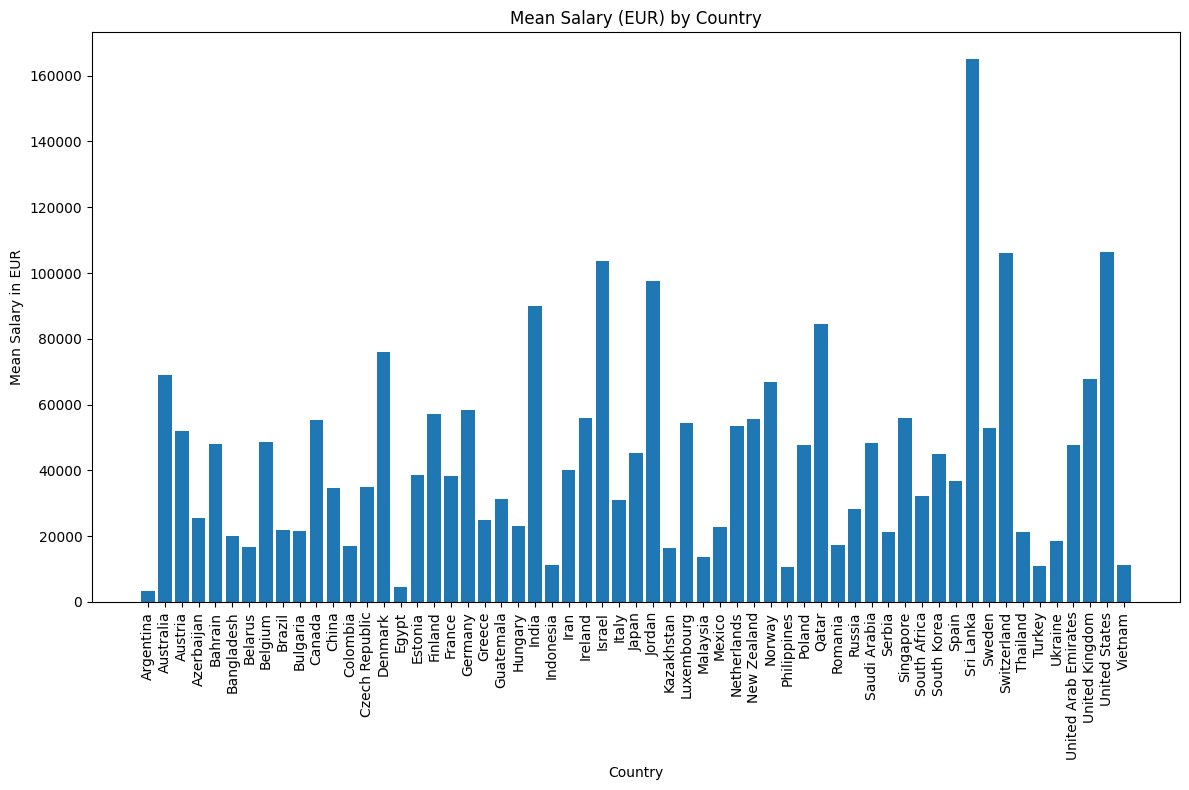

In [163]:
plt.figure(figsize=(12, 8))
plt.bar(grouped_mean_data['country'], grouped_mean_data['EUR_median'])
plt.xlabel('Country')
plt.ylabel('Mean Salary in EUR')
plt.title('Mean Salary (EUR) by Country')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Wnioski